In [2]:
import os
%matplotlib inline
import matplotlib.pyplot as plt # Data Visualization
import pandas as pd # Data processing
import seaborn as sns # Data Visualization
import numpy as np # Linear Algebra
import h5py #To read h5 file



# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Importing all necessary tensorflow keras libraries
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import linear
from tensorflow.keras import utils 

from sklearn import metrics


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
os.chdir('/gdrive/MyDrive/Colab Notebooks')

### 1. Import the data.

In [5]:
# Open the file as readonly
h5f = h5py.File('SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
# Close this file
h5f.close()

In [6]:
# Check the shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (42000, 32, 32)
y_train shape: (42000,)
X_test shape: (18000, 32, 32)
y_test shape: (18000,)


In [7]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))


[[   0    1    2    3    4    5    6    7    8    9]
 [4186 4172 4197 4281 4188 4232 4168 4192 4188 4196]]


In [8]:
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5    6    7    8    9]
 [1814 1828 1803 1719 1812 1768 1832 1808 1812 1804]]


### 2. Data pre-processing and visualisation

7 2 9 0 9 1 8 4 4 8 
9 1 4 3 5 8 6 5 5 0 
6 5 8 3 2 0 1 9 5 2 
8 9 1 0 9 5 3 3 7 6 
4 2 4 9 6 7 8 8 3 5 


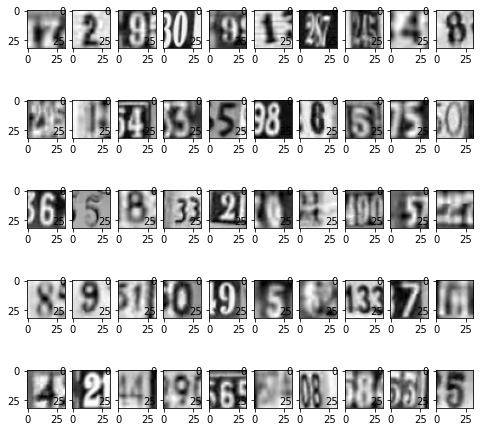

In [9]:
# Checking the images
columns = 10
rows = 5

fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows + 1):
    img = X_test[i]
    fig.add_subplot(rows, columns, i)
    print (y_test[i], end=' ')
    if i % columns == 0:
      print ("")
    plt.imshow(img, cmap='gray')

plt.show()

In [10]:
# Reshaping input image data from 2D to 1 D -- (32 x 32) to 1024 
X_train = X_train.reshape(X_train.shape[0], 1024) 
X_test = X_test.reshape(X_test.shape[0], 1024) 
# convert the input values to float32 
X_train = X_train.astype( np.float32) 
X_test = X_test.astype( np.float32) 

# normalize the values of image vectors to fit under 1 
X_train /= 255.0 
X_test /= 255.0


In [11]:
# convert output data into one hot encoded format 
y_train = utils.to_categorical( y_train, 10) 
y_test = utils.to_categorical( y_test, 10)

In [ ]:
pd.DataFrame(y_train).value_counts()

0    1    2    3    4    5    6    7    8    9  
0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0    4281
               0.0  0.0  1.0  0.0  0.0  0.0  0.0    4232
          1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    4197
          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0    4196
                                   1.0  0.0  0.0    4192
                    1.0  0.0  0.0  0.0  0.0  0.0    4188
                    0.0  0.0  0.0  0.0  1.0  0.0    4188
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    4186
0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    4172
     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0    4168
dtype: int64

### 3. Design, train, tune and test a neural network image classifier.

In [12]:
def Build_Model():
  model = Sequential()
  model.add(Dense(units = 1024,kernel_initializer='he_normal', input_shape =(1024,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(Dense(units = 512,kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(units = 256, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(units = 128, kernel_initializer='he_normal')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(units = 64, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add( Dense( units = 32, kernel_initializer='he_normal')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(10,activation='softmax'))  #Classify the input among ten classes using Softmax Activation
  return model

def evaluate(model, opti, n_epochs = 20 , batch_size = 32):
  #model.summary()
  model.compile(optimizer= opti, loss ='categorical_crossentropy', metrics =['accuracy'])
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1, verbose=False) #train the model
  train = pd.DataFrame(history.history['accuracy']).iloc[(n_epochs-1),0]
  val = pd.DataFrame(history.history['val_accuracy']).iloc[(n_epochs-1),0]
  loss, acc  = model.evaluate(X_test, y_test, verbose=False)
  return (train,val,acc)

In [ ]:
#Compile the above neuron strcuture through various optimizers in keras and check the best one
# Table to save the results
opt_tab = pd.DataFrame(columns=['optimizer','Learning_Rate','Training_Accuracy','Validation_Accuracy','Testing_Accuracy'])

In [ ]:
lrr = 0.001
rms = tf.keras.optimizers.RMSprop( learning_rate=lrr, momentum=0.1)
adad = tf.keras.optimizers.Adadelta(learning_rate=lrr, rho=0.95,epsilon=1e-07)
adam = tf.keras.optimizers.Adam(lr=lrr)
sgd = tf.keras.optimizers.SGD(lr = lrr)
adag = tf.keras.optimizers.Adagrad(lr=lrr, initial_accumulator_value=0.1, epsilon=1e-07)
opt = [rms, adam, adad, sgd, adag]
n_epochs = 20 #No of epochs
batch_size = 32 #batch size for training 
for i in opt:
  model = Build_Model()
  (train, val, acc) = evaluate(model,i)
  j= str(i.__class__).split('.')[-1].replace('\'', '').replace('>', '')
  new_row = {'optimizer': j ,'Learning_Rate':lrr, 'Training_Accuracy': np.round((train*100),2) ,'Validation_Accuracy':np.round((val*100),2),'Testing_Accuracy':np.round((acc*100),2)}
  opt_tab = opt_tab.append(new_row, ignore_index=True)

In [ ]:
opt_tab

,optimizer,Learning_Rate,Training_Accuracy,Validation_Accuracy,Testing_Accuracy
0,RMSprop,0.050,9.88,9.64,10.02
1,Adam,0.050,10.19,10.62,10.16
2,Adadelta,0.050,85.74,76.17,75.26
3,SGD,0.050,87.76,52.10,51.25
4,Adagrad,0.050,88.75,74.69,75.53
5,RMSprop,0.001,86.83,74.43,73.89
6,Adam,0.001,86.72,78.98,78.71
7,Adadelta,0.001,29.45,31.86,30.95
8,SGD,0.001,72.04,72.02,72.23
9,Adagrad,0.001,73.00,74.33,73.59


### Inference:
* With modification in learning rate and remaining model neuron structure intact we find Adagrad (lr = 0.05) and Adam (lr = 0.001) to give better results. 
* With  Adagrad  and Adam either, we will see if any further hyperparameters can adjusted to improve the model.

In [30]:
# Table to save the results
tab = pd.DataFrame(columns=['optimizer','Learning_Rate','Epochs','Training_Accuracy','Training_Loss','Validation_Accuracy','Validation_Loss','Testing_Accuracy', 'Testing_Loss'])

#### With learning rate 0.0005 and Adam Algorithm:

In [27]:
n_epochs = 100
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)
lrr = 0.0005
adam = tf.keras.optimizers.Adam(lr=lrr)
#adag = tf.keras.optimizers.Adagrad(lr=lrr, initial_accumulator_value=0.1, epsilon=1e-07)
opt = adam
j = str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
print('Optimizer:', j , '\n' )
model = Build_Model()
model.summary()
model.compile(optimizer= opt, loss ='categorical_crossentropy', metrics =['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1, callbacks = [es], verbose=True) #train the model

Optimizer: Adam 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_18 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 

In [28]:
best_epoch = (pd.DataFrame(history.history['val_accuracy']).shape[0] - 1)
j= str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
# Scores achieved for the model
validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[best_epoch,0]
Train_accuracy = pd.DataFrame(history.history['accuracy']).iloc[best_epoch,0]
validation_loss = pd.DataFrame(history.history['val_loss']).iloc[best_epoch,0]
Train_loss = pd.DataFrame(history.history['loss']).iloc[best_epoch,0]
print('With',best_epoch,'epocs and using' , j , 'optimizer we get below results')
print('Training Accuracy: %.2f and loss: %.2f' %(Train_accuracy*100, Train_loss)  )
print('Validation Accuracy: %.2f and loss :%.2f' %(validation_accuracy*100, validation_loss))
loss,accuracy  = model.evaluate(X_test, y_test, verbose=False)
print('Model accuracy : %.2f and loss :%.2f' %(accuracy*100, loss))

With 10 epocs and using Adam optimizer we get below results
Training Accuracy: 85.15 and loss: 0.47
Validation Accuracy: 74.21 and loss :0.81
Model accuracy : 73.67 and loss :0.84


In [31]:
new_row = {'optimizer': j ,'Learning_Rate':lrr,'Epochs':best_epoch, 'Training_Accuracy': np.round((Train_accuracy*100),2) ,'Training_Loss':Train_loss,'Validation_Accuracy':np.round((validation_accuracy*100),2),'Validation_Loss':validation_loss,'Testing_Accuracy':np.round((accuracy*100),2),'Testing_Loss':loss}
tab = tab.append(new_row, ignore_index=True)
tab

,optimizer,Learning_Rate,Epochs,Training_Accuracy,Training_Loss,Validation_Accuracy,Validation_Loss,Testing_Accuracy,Testing_Loss
0,Adam,0.0005,10,85.15,0.46629,74.21,0.808434,73.67,0.843503


#### With learning rate 0.001 and Adam Algorithm:

In [32]:
n_epochs = 100
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)
lrr = 0.001
adam = tf.keras.optimizers.Adam(lr=lrr)
#adag = tf.keras.optimizers.Adagrad(lr=lrr, initial_accumulator_value=0.1, epsilon=1e-07)
opt = adam
j = str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
print('Optimizer:', j , '\n' )
model = Build_Model()
model.summary()
model.compile(optimizer= opt, loss ='categorical_crossentropy', metrics =['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1, callbacks = [es], verbose=True) #train the model

Optimizer: Adam 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_24 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_24 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
activation_25 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 

In [33]:
best_epoch = (pd.DataFrame(history.history['val_accuracy']).shape[0] - 1)
j= str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
# Scores achieved for the model
validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[best_epoch,0]
Train_accuracy = pd.DataFrame(history.history['accuracy']).iloc[best_epoch,0]
validation_loss = pd.DataFrame(history.history['val_loss']).iloc[best_epoch,0]
Train_loss = pd.DataFrame(history.history['loss']).iloc[best_epoch,0]
print('With',best_epoch,'epocs and using' , j , 'optimizer we get below results')
print('Training Accuracy: %.2f and loss: %.2f' %(Train_accuracy*100, Train_loss)  )
print('Validation Accuracy: %.2f and loss :%.2f' %(validation_accuracy*100, validation_loss))
loss,accuracy  = model.evaluate(X_test, y_test, verbose=False)
print('Model accuracy : %.2f and loss :%.2f' %(accuracy*100, loss))

With 10 epocs and using Adam optimizer we get below results
Training Accuracy: 84.80 and loss: 0.48
Validation Accuracy: 69.50 and loss :0.95
Model accuracy : 69.47 and loss :0.98


In [34]:
new_row = {'optimizer': j ,'Learning_Rate':lrr,'Epochs':best_epoch, 'Training_Accuracy': np.round((Train_accuracy*100),2) ,'Training_Loss':Train_loss,'Validation_Accuracy':np.round((validation_accuracy*100),2),'Validation_Loss':validation_loss,'Testing_Accuracy':np.round((accuracy*100),2),'Testing_Loss':loss}
tab = tab.append(new_row, ignore_index=True)
tab

,optimizer,Learning_Rate,Epochs,Training_Accuracy,Training_Loss,Validation_Accuracy,Validation_Loss,Testing_Accuracy,Testing_Loss
0,Adam,0.0005,10,85.15,0.466290,74.21,0.808434,73.67,0.843503
1,Adam,0.0010,10,84.80,0.475845,69.50,0.951094,69.47,0.980534


#### With learning rate 0.05 and Adagrad Algorithm:

In [35]:
n_epochs = 100
batch_size = 64
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
lrr = 0.05
#adam = tf.keras.optimizers.Adam(lr=lrr)
adag = tf.keras.optimizers.Adagrad(lr=lrr, initial_accumulator_value=0.1, epsilon=1e-07)
opt = adag
j = str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
print('Optimizer:', j , '\n' )
model = Build_Model()
model.summary()
model.compile(optimizer= opt, loss ='categorical_crossentropy', metrics =['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1, callbacks = [es], verbose=True) #train the model

Optimizer: Adagrad 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_30 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_30 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
activation_31 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (Non

In [36]:
best_epoch = (pd.DataFrame(history.history['val_accuracy']).shape[0] - 1)
j= str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
# Scores achieved for the model
validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[best_epoch,0]
Train_accuracy = pd.DataFrame(history.history['accuracy']).iloc[best_epoch,0]
validation_loss = pd.DataFrame(history.history['val_loss']).iloc[best_epoch,0]
Train_loss = pd.DataFrame(history.history['loss']).iloc[best_epoch,0]
print('With',best_epoch,'epocs and using' , j , 'optimizer we get below results')
print('Training Accuracy: %.2f and loss: %.2f' %(Train_accuracy*100, Train_loss)  )
print('Validation Accuracy: %.2f and loss :%.2f' %(validation_accuracy*100, validation_loss))
loss,accuracy  = model.evaluate(X_test, y_test, verbose=False)
print('Model accuracy : %.2f and loss :%.2f' %(accuracy*100, loss))

With 29 epocs and using Adagrad optimizer we get below results
Training Accuracy: 94.53 and loss: 0.17
Validation Accuracy: 76.88 and loss :0.91
Model accuracy : 77.04 and loss :0.91


In [37]:
new_row = {'optimizer': j ,'Learning_Rate':lrr,'Epochs':best_epoch, 'Training_Accuracy': np.round((Train_accuracy*100),2) ,'Training_Loss':Train_loss,'Validation_Accuracy':np.round((validation_accuracy*100),2),'Validation_Loss':validation_loss,'Testing_Accuracy':np.round((accuracy*100),2),'Testing_Loss':loss}
tab = tab.append(new_row, ignore_index=True)
tab

,optimizer,Learning_Rate,Epochs,Training_Accuracy,Training_Loss,Validation_Accuracy,Validation_Loss,Testing_Accuracy,Testing_Loss
0,Adam,0.0005,10,85.15,0.466290,74.21,0.808434,73.67,0.843503
1,Adam,0.0010,10,84.80,0.475845,69.50,0.951094,69.47,0.980534
2,Adagrad,0.0500,29,94.53,0.165234,76.88,0.907355,77.04,0.906456


#### With learning rate 0.005 and Adagrad Algorithm:

In [38]:
n_epochs = 100
batch_size = 64
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
lrr = 0.005
#adam = tf.keras.optimizers.Adam(lr=lrr)
adag = tf.keras.optimizers.Adagrad(lr=lrr, initial_accumulator_value=0.1, epsilon=1e-07)
opt = adag
j = str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
print('Optimizer:', j , '\n' )
model = Build_Model()
model.summary()
model.compile(optimizer= opt, loss ='categorical_crossentropy', metrics =['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1, callbacks = [es], verbose=True) #train the model

Optimizer: Adagrad 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_36 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_36 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_37 (Batc (None, 512)               2048      
_________________________________________________________________
activation_37 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (Non

In [39]:
best_epoch = (pd.DataFrame(history.history['val_accuracy']).shape[0] - 1)
j= str(opt.__class__).split('.')[-1].replace('\'', '').replace('>', '')
# Scores achieved for the model
validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[best_epoch,0]
Train_accuracy = pd.DataFrame(history.history['accuracy']).iloc[best_epoch,0]
validation_loss = pd.DataFrame(history.history['val_loss']).iloc[best_epoch,0]
Train_loss = pd.DataFrame(history.history['loss']).iloc[best_epoch,0]
print('With',best_epoch,'epocs and using' , j , 'optimizer we get below results')
print('Training Accuracy: %.2f and loss: %.2f' %(Train_accuracy*100, Train_loss)  )
print('Validation Accuracy: %.2f and loss :%.2f' %(validation_accuracy*100, validation_loss))
loss,accuracy  = model.evaluate(X_test, y_test, verbose=False)
print('Model accuracy : %.2f and loss :%.2f' %(accuracy*100, loss))

With 39 epocs and using Adagrad optimizer we get below results
Training Accuracy: 95.75 and loss: 0.15
Validation Accuracy: 77.95 and loss :0.80
Model accuracy : 77.62 and loss :0.82


In [40]:
new_row = {'optimizer': j ,'Learning_Rate':lrr,'Epochs':best_epoch, 'Training_Accuracy': np.round((Train_accuracy*100),2) ,'Training_Loss':Train_loss,'Validation_Accuracy':np.round((validation_accuracy*100),2),'Validation_Loss':validation_loss,'Testing_Accuracy':np.round((accuracy*100),2),'Testing_Loss':loss}
tab = tab.append(new_row, ignore_index=True)
tab

,optimizer,Learning_Rate,Epochs,Training_Accuracy,Training_Loss,Validation_Accuracy,Validation_Loss,Testing_Accuracy,Testing_Loss
0,Adam,0.0005,10,85.15,0.466290,74.21,0.808434,73.67,0.843503
1,Adam,0.0010,10,84.80,0.475845,69.50,0.951094,69.47,0.980534
2,Adagrad,0.0500,29,94.53,0.165234,76.88,0.907355,77.04,0.906456
3,Adagrad,0.0050,39,95.75,0.146679,77.95,0.802457,77.62,0.818894


### 4. Plot the training loss, validation loss vs number of epochs and training accuracy, validation accuracy vs number of epochs plot and write your observations on the same.

In [41]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='training_accuracy')
  plt.plot(history.history['val_accuracy'], label='validation_accuracy')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend(['training', 'validation'], loc='best')
  plt.grid(True)

def plot_loss(history):
  plt.plot(history.history['loss'], label='training_loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='best')
  plt.grid(True)

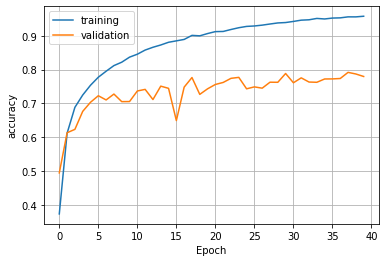

In [42]:
# Accuracy vs Epochs
plot_accuracy(history)

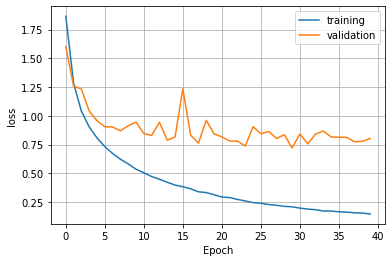

In [43]:
# Loss vs Epochs
plot_loss(history)

### Summary

* In above model seven dense layers were used in the architecture. 
* To allow every layer to learn independently batch normalization was applied. Also using batch normalization learning becomes efficient and helps regularization to avoid overfitting of the model.
* To use both ReLu activation and batch normalization, the activation was applied after batch normalization.
* Later we tried to check with various optimizers with fixed learning rate and fixed no of epochs , which one can give best results. Here we found Adagrad and Adam algorithm to better results. The results were tabulated in 'opt_tab'.
* Then with Adam algorithm , by modifying learning rate and early stopping (monitored Validation Loss) we found out the best results. Similiar we modified learning rate and epochs using Adagrad algorithm and tabulated the results in 'tab'
* Observing the results we get best results with Adagrad algorithm with learning rate as 0.005.
* We also observe that even with hyperparameters tuning we are able to improve training score however the score on validation and test data sets have not improved more than 80%. This is an indication that the model is getting overfitted.
* Hence with dense neural network we cannot improve the results beyond a limit howmuch we try to adjust the hyperparameters. we get either under fit or over fit. The optimized model will give average results. 
* Even with dense neural network it is important we improve the input data or cleans the images before applying ANN. This is done in CNN which will provide betters results than ANN.


### Thank You!!